# Objetivo

Usando Fast.ai, fazer a diferenciação entre coruja e falcão

# Modelagem

## Passo 1 - Obter Dataset

Para buscar as imagens será utilizado o DuckDuckGo que é um motor de busca online. Para isso, utilizando o Jupyter Notebook, realize o comando abaixo para a fazer a instalação.

In [ ]:
!pip install -Uqq duckduckgo_search

**OBS.:** Quando fui fazer a instalação foi apresentado o seguinte erro:

"**ERROR:** pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible."

O problema foi resolvido utilizando os comandos abaixo em ordem:

In [1]:
! pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 26.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


Atualiza o gerenciador de pacotes *pip*

In [2]:
! pip install wheel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Instala a ferramenta *wheel*

In [3]:
! pip install jedi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.8 MB/s eta 0:00:00


Instala a ferramenta *jedi*

In [4]:
! pip install --upgrade setuptools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0


Instala a ferramenta *setuptools*

In [1]:
! pip install -Uqq duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 10.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


Instala a biblioteca *DuckDuckGo*

Após realizada a atualização de todas as dependências iremos criar a função que faz a busca das imagens utilando o DuckDuckGo

In [20]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=250): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Primeiramente vamos buscar pela imagem de uma coruja para verificar se a busca está condizente com o que queremos.

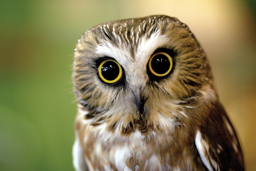

In [21]:
from fastdownload import download_url
from fastai.vision.all import *

download_url(search_images('owel photos', max_images=1)[0], 'owel.jpg', show_progress=False)
Image.open('owel.jpg').to_thumb(256,256)


Agora vamos fazer o mesmo com uma imagem de um falcão.

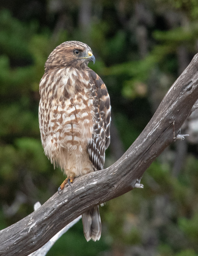

In [22]:
download_url(search_images('hawk photos', max_images=1)[0], 'hawk.jpg', show_progress=False)
Image.open('hawk.jpg').to_thumb(256,256)

Após isso, iremos agora buscar 250 imagens de corujas e falcões salvando os diferentes grupos de fotos em diferentes diretórios

In [23]:
searches = 'hawk','owel'
path = Path('hawk_or_owel')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pausas entre as pesquisas para evitar sobrecarga no servidor
    resize_images(path/o, max_size=400, dest=path/o)

## Passo 2 - Treinar o modelo

Algumas fotos podem não ser baixadas corretamente, o que pode fazer com que nosso treinamento de modelo falhe, então vamos removê-las:


In [24]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Para treinarmos o modelo precisaremos do conjunto de treinamento e o conjunto de validação (avaliar a precisão do modelo). Para isso será utilizado o DataBlock que é um objeto do Fast.ai para ajudar nessa criação

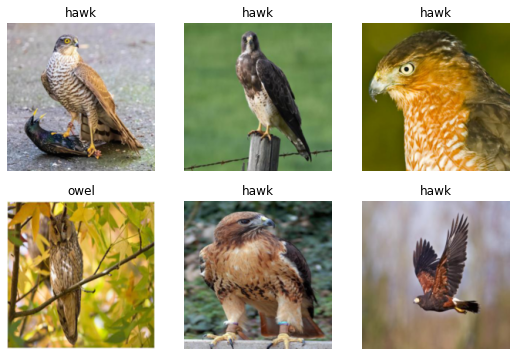

In [31]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Iremos utilizar a função Fine Tune do Fast.ai que usa pesos de uma rede já treinada como valores iniciais para treinar uma nova rede. Nesse caso será usado o modelo resnet18 do torchvision conforme consta na documentação do Fast.ai.

Clique [aqui](https://fastai1.fast.ai/vision.models.html) e saiba mais.

In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.906395,0.453246,0.162338,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.258400,0.133380,0.038961,01:28
1,0.171180,0.069499,0.019481,01:34
2,0.123209,0.046570,0.012987,01:30
3,0.090683,0.033489,0.012987,01:29
4,0.069390,0.037781,0.012987,01:26
5,0.055597,0.038968,0.012987,01:26


Agora vamos fazer um teste, verificando o que o modelo acha sobre a imagem do falcão que achamos anteriormente.

In [30]:
is_hawk,_,probs = learn.predict(PILImage.create('hawk.jpg'))
print(f"Isso é um: {is_hawk}.")
print(f"Probabilidade de ser um hawk: {probs[0]:.4f}")

Isso é um: hawk.
Probabilidade de ser um hawk: 1.0000


# Conclusão

Na lição 1 do Fast.ai foi possível dar os primeiros passos no aprendizado de Machine Learning de forma prática e rápida aprendendo conceitos importantes como Validation Set, Training Set, DataBlock, além do processo de construção de um Modelo e como ajustá-lo, buscar imagens.